In [1583]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.weightstats import zconfint
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split, ShuffleSplit, \
    cross_val_score, learning_curve, train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
%matplotlib inline

In [1584]:
DATASET_PATH = './Lesson 1/data/course_project/train.csv'
PREP_DATASET_PATH = '.Lesson 1/data/course_project/test.csv'

# output
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

SCALER_FILE_PATH = '../scaler.pkl'
MODEL_FILE_PATH = '../model.pkl'


### Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка данных

In [1585]:
df = pd.read_csv(DATASET_PATH)

In [1586]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [1587]:
df.shape

(7500, 17)

In [1588]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обработка пропусков<a class="anchor" id="gaps"></a>

In [1589]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Обзор номинативных признаков**

* **Home Ownership** - Дом (1 = владелец, 2 = ипотека, 3 = аренда, 4 =Have Mortgage)
* **Purpose** - Цель (0 = debt consolidation, 1 = other, 2 = home improvements, 3 = business loan, 4 = buy a car,
5 = medical bills, 6 = major purchase, 7 = take a trip, 8 = buy house, 9 = small business, 10= wedding, 11 = moving,                    11
12 = educational expenses, 15= vacation, 16 = renewable energy)
* **'Term'** - Срок кредита (0 = long term, 1 = short term)
* **Years in current job** -(0= 10+ years, 1 = 2 years, 2 = 3 years, 3 = < 1 year, 4 = 5 years, 5 = 1 year, 6 = 4 years,
7=6 years, 8= 7 years, 9 =8 years, 10 = 9 years)

In [1590]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обзор данных<a class="anchor" id="review"></a>

**Обзор и выделение целевой переменной**

In [1591]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE = df.columns
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)
df[TARGET_NAME].value_counts()
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term', 'Years in current job']
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',\
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent'\
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance','Monthly Debt'\
                     'Credit Score' 'Credit Default']

In [1592]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)


In [1593]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1594]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring='f1',
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [1595]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)

    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns,
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

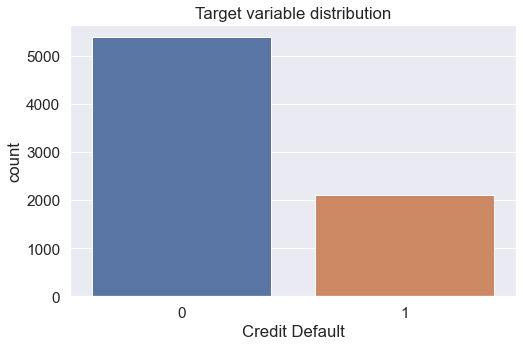

In [1596]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()






### Построение новых признаков<a class="anchor" id="new_features"></a>

* замена клонок с признаками (obj) на колонки с цифрами
* Пропуски в Months since last delinquent, Annual Income,  Сredit Score меняем на среднее или моду



In [1597]:
df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage':'0', 'Own Home':'1', 'Rent':'2', 'Have Mortgage':'0' }).astype(int)
df['Purpose'] = df['Purpose'].map({'debt consolidation':'0', 'other':'1', 'home improvements':'2', 'business loan':'3', 'buy a car':'4',
'medical bills':'5', 'major purchase':'6', 'take a trip':'7', 'buy house':'8', 'small business':'9', 'wedding':'10', 'moving':'11',
'educational expenses':'12', 'vacation':'13', 'renewable energy':'14' }).astype(int)
df['Term'] = df['Term'].map({'Long Term':'0', 'Short Term':'1'}).astype(int)

In [1598]:
df['Years in current job'] = df['Years in current job'].map({'10+ years':'10', '2 years':'2', '3 years':'3', '<1 year':'0', '5 years':'5',
'1 year':'1', '4 years':'4', '6 years':'6', '7 years':'7', '8 years':'8', '9 years':'9'}).astype(float)

In [1599]:
#df['Years in current job'].replace('', np.nan, inplace=True)
df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])

In [1600]:
df['Years in current job'].value_counts()

10.0    3266
2.0      705
3.0      620
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

In [1601]:
#df['Bankruptcies'].replace('', mean, axis= 0, inplace=True)
#df['Annual Income'].replace('', np.nan, inplace=True)
#df['Months since last delinquent'].replace('', np.nan, inplace=True)
#df['Credit Score'].replace('', np.nan, inplace=True)
df['Bankruptcies']=df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])

In [1602]:
df['Annual Income']=df['Annual Income'].fillna(df['Annual Income'].mode()[0])

In [1603]:
df['Months since last delinquent']=df['Months since last delinquent'].fillna(df['Months since last delinquent'].mode()[0])

In [1604]:
df['Credit Score']=df['Credit Score'].fillna(df['Credit Score'].mode()[0])


In [1605]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Home Ownership                       2.00
Annual Income                   568841.00
Years in current job                 6.00
Tax Liens                            0.00
Number of Open Accounts              6.00
Years of Credit History              8.30
Maximum Open Credit             514272.00
Number of Credit Problems            0.00
Months since last delinquent        15.00
Bankruptcies                         0.00
Purpose                              0.00
Term                                 1.00
Current Loan Amount             339713.00
Current Credit Balance          246149.75
Monthly Debt                     13750.50
Credit Score                        22.00
Credit Default                       1.00
dtype: float64


In [1606]:
#df = df[~((df < (Q1-4 * IQR)) |(df > (Q3 + 4 * IQR))).any(axis=1)]

#df.shape
# принципиально после удаления выбросов в статистике снизу при смене параметров ничего не меняется

In [1607]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,1,482087.0,10.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,0,1,99999999.0,47386.0,7914.0,749.0,0
1,1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0,0,264968.0,394972.0,18373.0,737.0,1
2,0,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,0,1,99999999.0,308389.0,13651.0,742.0,0
3,1,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,0,1,121396.0,95855.0,11338.0,694.0,0
4,2,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,0,1,125840.0,93309.0,7180.0,719.0,0


In [1608]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [1609]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int32  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int32  
 11  Term                          7500 non-null   int32  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1610]:
df.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,0.940667,1.283992e+06,6.834800,0.030133,11.130933,18.317467,9.451537e+05,0.170000,23.433067,0.116933,0.552400,0.740800,1.187318e+07,2.898332e+05,18314.454133,1065.745733,0.281733
std,0.954114,7.695113e+05,3.326167,0.271604,4.908924,7.041946,1.602622e+07,0.498598,17.906245,0.346904,1.551293,0.438225,3.192612e+07,3.178714e+05,11926.764673,1437.907935,0.449874
min,0.000000,1.645970e+05,1.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,0.000000,9.311330e+05,4.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,14.000000,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.000000,9.891305e+05,8.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,14.000000,0.000000,0.000000,1.000000,3.095730e+05,2.093230e+05,16076.500000,738.000000,0.000000
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,0.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,2.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обработка выбросов<a class="anchor" id="outliers"></a>

<AxesSubplot:>

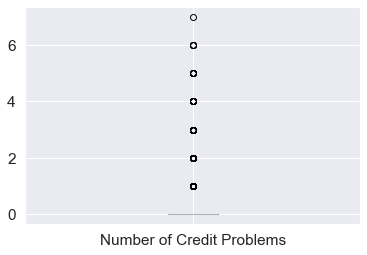

In [1611]:
name_col = ['Number of Credit Problems']
df.boxplot(name_col)

<AxesSubplot:>

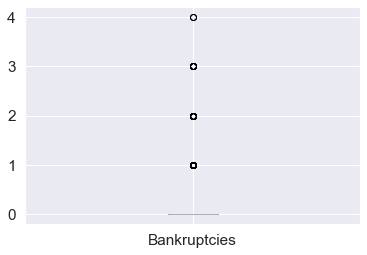

In [1612]:
name_col = ['Bankruptcies']
df.boxplot(name_col)

<AxesSubplot:>

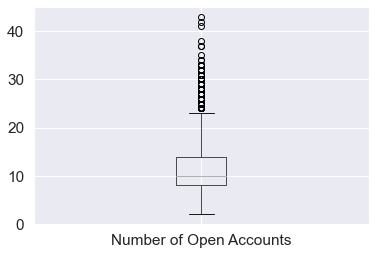

In [1613]:
df.boxplot('Number of Open Accounts')

<AxesSubplot:>

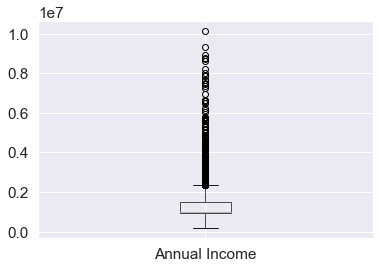

In [1614]:
df.boxplot('Annual Income')

<AxesSubplot:>

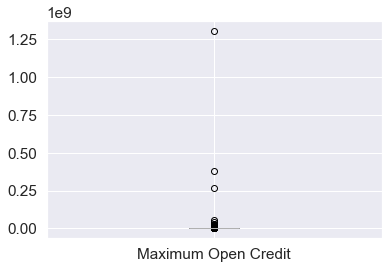

In [1615]:
df.boxplot('Maximum Open Credit')


<AxesSubplot:>

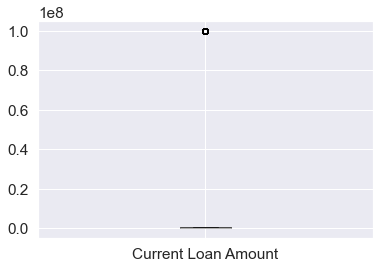

In [1616]:
df.boxplot('Current Loan Amount')

<AxesSubplot:>

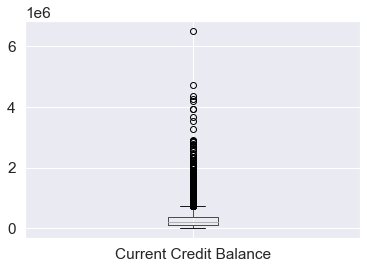

In [1617]:
df.boxplot('Current Credit Balance')

<AxesSubplot:>

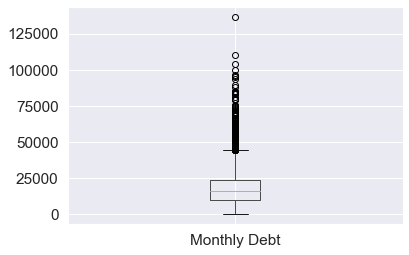

In [1618]:
df.boxplot('Monthly Debt')

<AxesSubplot:>

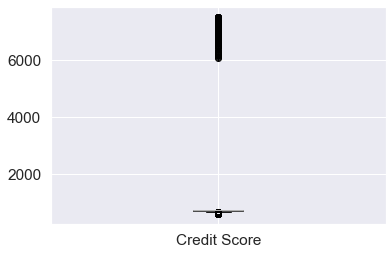

In [1619]:
df.boxplot('Credit Score')

<AxesSubplot:>

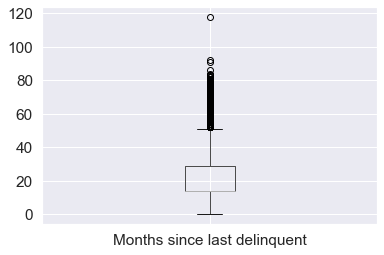

In [1620]:
df.boxplot('Months since last delinquent')

<AxesSubplot:>

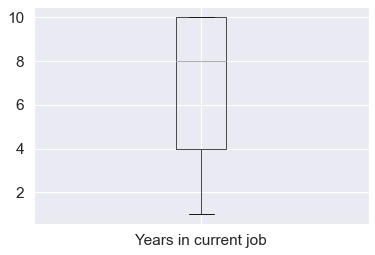

In [1621]:
df.boxplot('Years in current job')

Корреляция целевой переменной с базовыми признаками

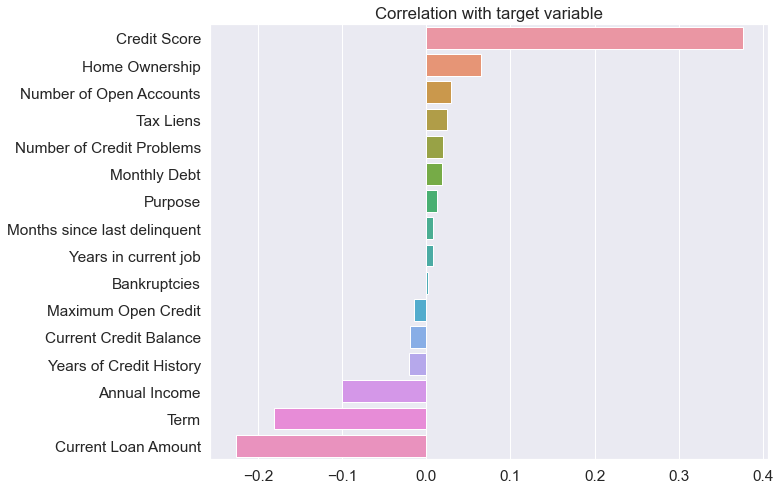

In [1622]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()


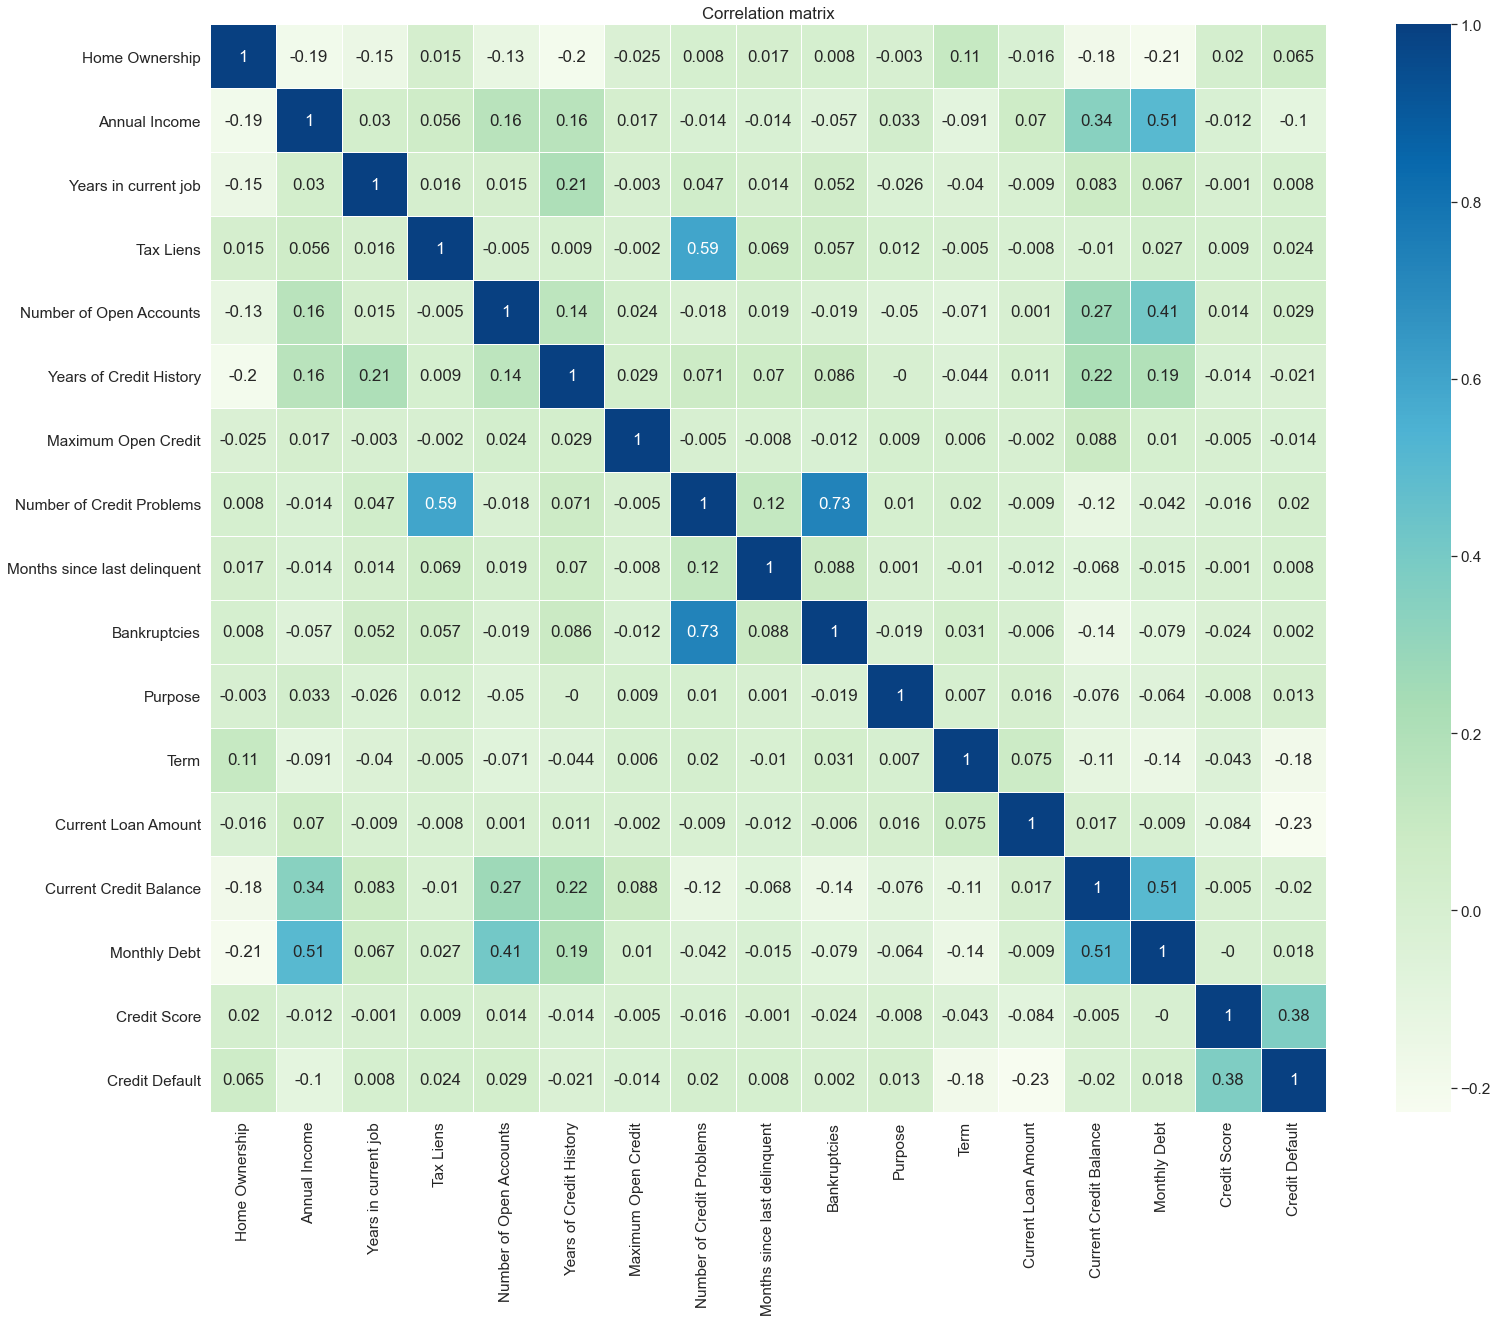

In [1623]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()


**Оценка признака "Credit Score" и др коррелиоующих признаков в разрезе целевой переменной**

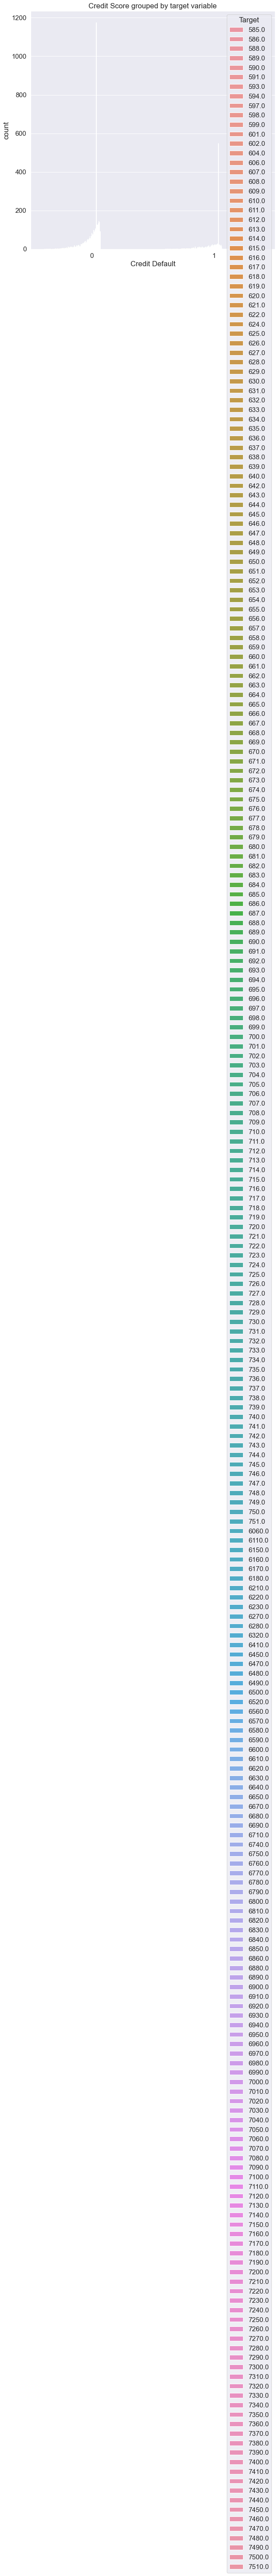

In [1624]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Credit Score', data=df)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

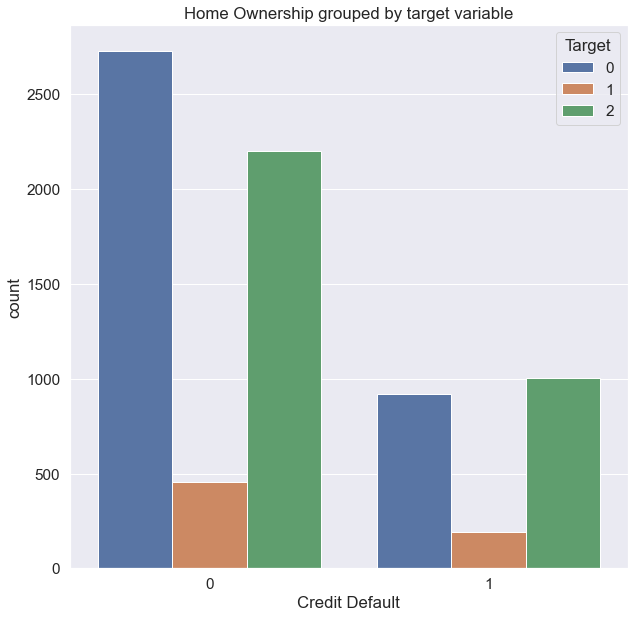

In [1625]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Home Ownership', data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

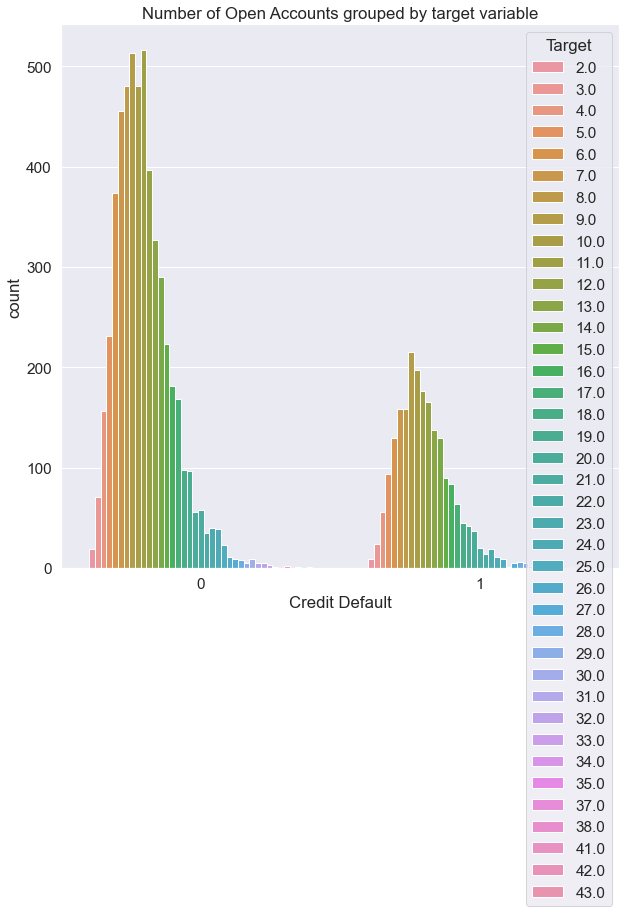

In [1626]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Number of Open Accounts', data=df)
plt.title('Number of Open Accounts grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

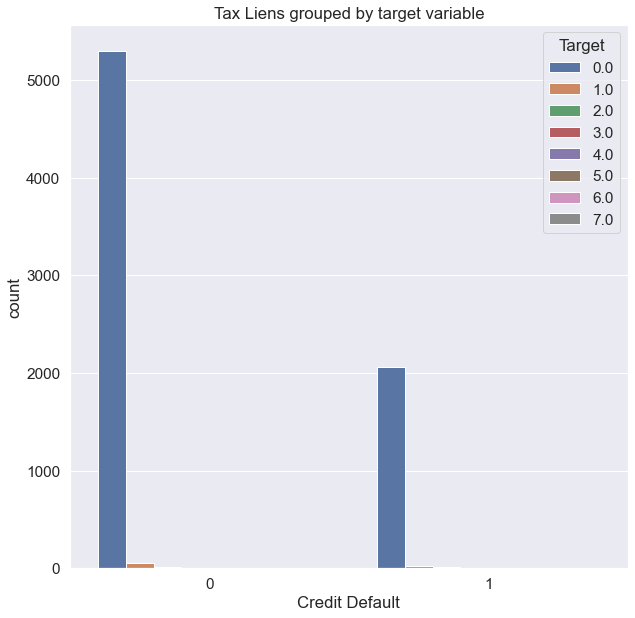

In [1627]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Tax Liens', data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

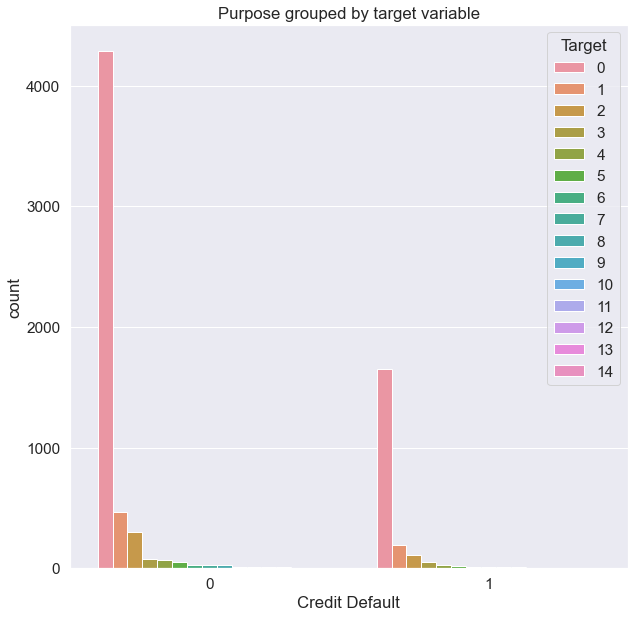

In [1628]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Purpose', data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

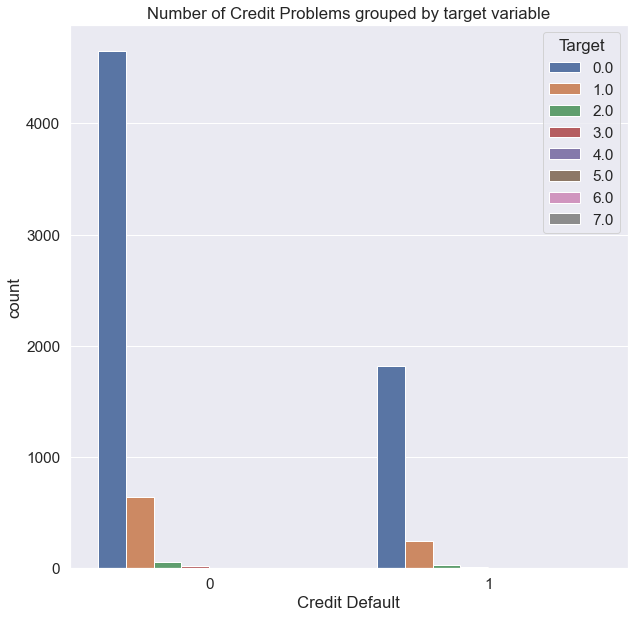

In [1629]:
plt.figure(figsize=(10, 10))

sns.countplot(x=TARGET_NAME, hue= 'Number of Credit Problems', data=df)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1630]:
# Total number of rows and columns
df.shape# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print('number of duplicate rows: ', duplicate_rows_df.shape)

number of duplicate rows:  (0, 17)


### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [1631]:
#df = df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
# не сохраняет


*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [1632]:
#CS_and_target_s = df.loc[df['Credit Score'].isin([-1, 0]), ['ID', 'Credit Score', 'Credit Default']].sample(1000)

# KeyError:"Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['ID'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [1633]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [1634]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Нормализация данных<a class="anchor" id="normalization"></a>

In [1635]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[BASE_FEATURE] = scaler.fit_transform(df_norm[BASE_FEATURE])

df = df_norm.copy()

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [1636]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [1637]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a>

In [1638]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [1639]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')


**Сохранение модели для нормализации данных**

In [1640]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a>

**Логистическая регрессия**

In [1641]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.75      0.71      3771
           1       0.63      0.54      0.58      2958

    accuracy                           0.66      6729
   macro avg       0.65      0.65      0.65      6729
weighted avg       0.66      0.66      0.66      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1616
           1       0.44      0.52      0.48       634

    accuracy                           0.68      2250
   macro avg       0.62      0.63      0.62      2250
weighted avg       0.70      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1199  417
1                305  329


**k ближайших соседей**

In [1642]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


c:\users\login\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\users\login\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3771
           1       0.74      0.70      0.72      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1616
           1       0.35      0.44      0.39       634

    accuracy                           0.61      2250
   macro avg       0.55      0.56      0.55      2250
weighted avg       0.64      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1103  513
1                358  276


*CatBoost*

In [1643]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3771
           1       0.94      0.85      0.89      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.90      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.47      0.51       634

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1370  246
1                333  301


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a>

In [1644]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [1645]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500, 2000],
          'max_depth':[3, 5, 7, 9]}

In [1646]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [1647]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 2min 12s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001CD6D209F40>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500,
                                                         2000]},
                   scoring='f1')

In [1648]:
rs.best_params_

{'n_estimators': 2000, 'max_depth': 3}

In [1649]:
rs.best_score_

0.5405068088906037

**Обучение и оценка финальной модели**

In [1650]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      3771
           1       0.80      0.64      0.71      2958

    accuracy                           0.77      6729
   macro avg       0.77      0.75      0.76      6729
weighted avg       0.77      0.77      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.51      0.52       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1339  277
1                310  324
Wall time: 1.81 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [1651]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.59      0.67      2958

    accuracy                           0.75      6729
   macro avg       0.76      0.73      0.73      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1616
           1       0.55      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1350  266
1                313  321


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [1652]:
final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

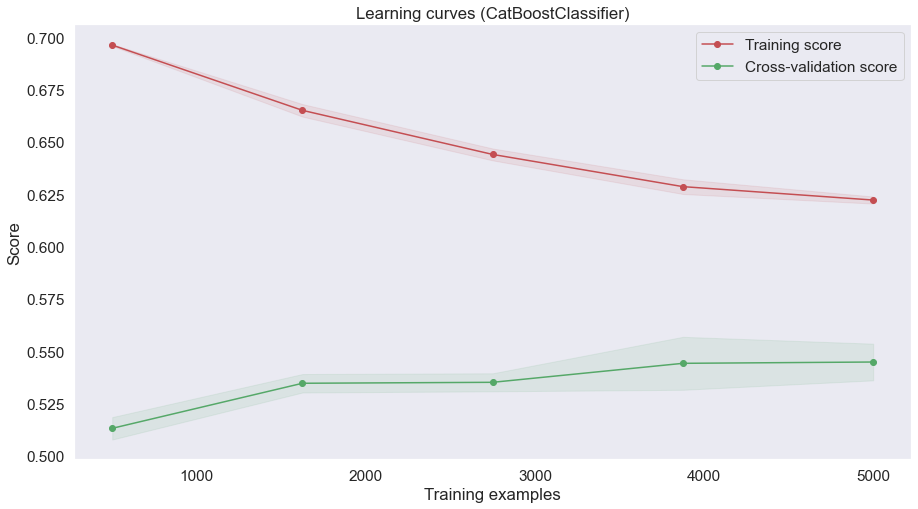

In [1653]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

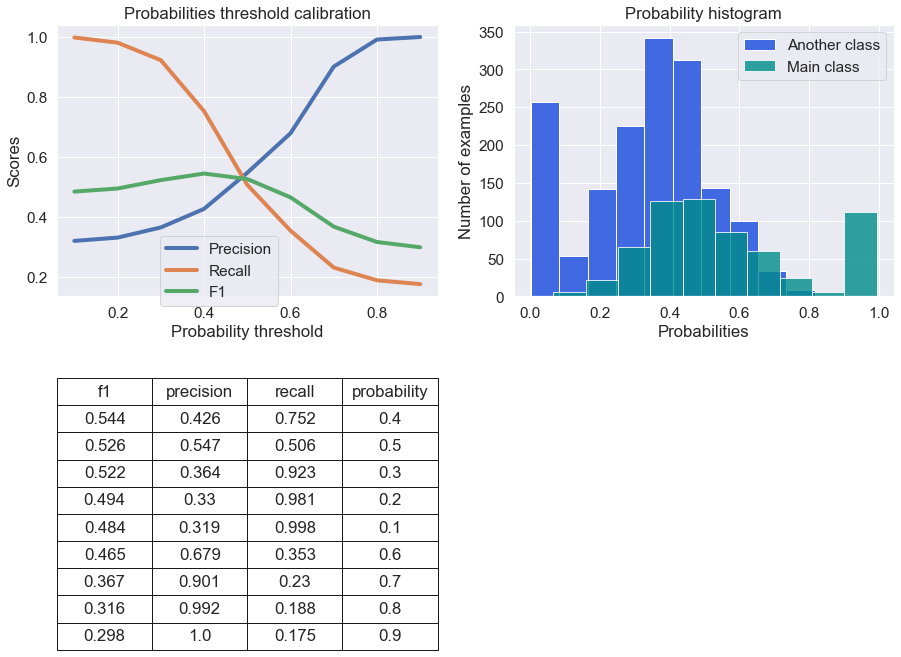

In [1654]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)


### Важность признаков<a class="anchor" id="feature_importances"></a>

In [1655]:
important_features_top = df.show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=5)
#Что тут надо поправить чтоб оно заработало?

AttributeError: 'DataFrame' object has no attribute 'show_feature_importances'

In [ ]:
important_features_top

### Финальная модель<a class="anchor" id="final_model"></a>

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=4000, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

